#### This is the Training of Models for the kaggle Housing Competition

In [78]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from utils import *


plt.style.use('deeplearning.mplstyle')

In [79]:
# Loading, Cleaning and One Hot Encoding Data
data = './data/train.csv'
df = modifying_data(data)

data before processing...
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePri

In [80]:
# Splitting Data into train and cross validation set
X = df.drop('SalePrice', axis=1)
Y = df['SalePrice']
print(len(X))

X = X.values
Y = Y.values

X_train, X_cv, Y_train, Y_cv = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_cv shape: {X_cv.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_cv shape: {Y_cv.shape}')


1460
X_train shape: (1168, 22)
X_cv shape: (292, 22)
Y_train shape: (1168,)
Y_cv shape: (292,)


Linear Regression Model 

In [81]:
# Building a linear regression model
degree = 4
polys = []
lr_models = []
scalers = []
lr = np.zeros((degree, 2))

for i in range(1, degree + 1):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_cv_poly = poly.transform(X_cv)
    polys.append(poly)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_cv_scaled = scaler.transform(X_cv_poly)
    scalers.append(scaler)
    
    print(f'Training Model with {i} degree polynomial')
    model = LinearRegression()
    model.fit(X_train_scaled, Y_train)
    lr_models.append(model)
    print(f'Trained Model with {i} degree polynomial')

    yhat = model.predict(X_train_scaled)
    error = root_mean_squared_error(Y_train, yhat) / 2
    lr[i-1, 0] = error
    
    yhat_cv = model.predict(X_cv_scaled)
    error_cv = root_mean_squared_error(Y_cv, yhat_cv) / 2
    lr[i-1, 1] = error_cv

# viewing results
for i in range(degree):
    print(f'Degree: {i + 1}, RMSE: {lr[i]}')


Training Model with 1 degree polynomial
Trained Model with 1 degree polynomial
Training Model with 2 degree polynomial
Trained Model with 2 degree polynomial
Training Model with 3 degree polynomial
Trained Model with 3 degree polynomial
Training Model with 4 degree polynomial
Trained Model with 4 degree polynomial
Degree: 1, RMSE: [17489.64264121 18369.58805506]
Degree: 2, RMSE: [ 9368.59824428 19082.51117349]
Degree: 3, RMSE: [1.11316599e+02 1.94547016e+06]
Degree: 4, RMSE: [1.11316599e+02 1.24669762e+06]


Neural Network Model

In [82]:
# Using tensorflow to build a model

def build_nn_model():
    tf.random.set_seed(42)

    model1 = Sequential(
        [
            Dense(120, activation='relu'),
            Dense(60, activation='relu'),
            Dense(30, activation='relu'),
            Dense(1, activation='linear')
        ],
        name='model1'
    )

    model2 = Sequential(
        [
            Dense(200, activation='relu'),
            Dense(150, activation='relu'),
            Dense(120, activation='relu'),
            Dense(100, activation='relu'),
            Dense(75, activation='relu'),
            Dense(50, activation='relu'),
            Dense(25, activation='relu'),
            Dense(1, activation='linear')
        ],
        name='model2'
    )

    model3 = Sequential(
        [
            Dense(50, activation='relu'),
            Dense(25, activation='relu'),
            Dense(1, activation='linear')
        ],
        name='model3'
    )

    model4 = Sequential(
        [
            Dense(300, activation='relu'),
            Dense(250, activation='relu'),
            Dense(200, activation='relu'),
            Dense(150, activation='relu'),
            Dense(100, activation='relu'),
            Dense(50, activation='relu'),
            Dense(25, activation='relu'),
            Dense(1, activation='linear')
        ],
        name='model4'
    )

    models_nn = [model1, model2, model3, model4]
    return models_nn

In [83]:
# Using XGBoost
def build_xgb_model():
    xg1 = xgb.XGBRegressor(n_estimators=100000, learning_rate=0.001, reg_lambda=6)
    xg2 = xgb.XGBRegressor(n_estimators=3000, learning_rate=0.03, max_depth=10, gamma=25, reg_lambda=10)
    xg3 = xgb.XGBRegressor(n_estimators=2700, learning_rate=0.01, max_depth=5, gamma=24, reg_lambda=1)
    xg4 = xgb.XGBRegressor(n_estimators=1500, learning_rate=0.03, max_depth=8, gamma=25, reg_lambda=2)

    xg1.name = 'xg1'
    xg2.name = 'xg2'
    xg3.name = 'xg3'
    xg4.name = 'xg4'

    return [xg1, xg2, xg3, xg4]


In [84]:
# Scaling the training data for the xgboost and nn model
nn_scaler = StandardScaler()
nn_train = nn_scaler.fit_transform(X_train)
nn_cv = nn_scaler.transform(X_cv)

In [85]:
# Training the neural network models
nn = np.zeros((4, 2))
models = build_nn_model()
i = 0
for model in models:
    scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=15, verbose=1)
    # compiling the loss on model
    model.compile(
        loss= 'mse',
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    )
    
    print(f'Training: {model.name}')
    model.fit(nn_train, Y_train, epochs= 300, verbose= 0, callbacks=[scheduler])
    
    print(f'Done Training: {model.name}')

    
    yhat = model.predict(nn_train)
    error = root_mean_squared_error(Y_train, yhat)
    nn[i, 0] = error
    
    yhat_cv = model.predict(nn_cv)
    error_cv = root_mean_squared_error(Y_cv, yhat_cv)
    nn[i, 1] = error_cv
    i += 1
print('Results:')
for i in range(len(models)):
    print(f'{models[i].name}: RMSE: {nn[i]}')

Training: model1
Done Training: model1
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Training: model2

Epoch 85: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Done Training: model2
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training: model3
Done Training: model3
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Training: model4

Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 278: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 293: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Done Training: model4
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Results:
model1: RMSE: [16741.77929688 36185.96875   ]
model2: RMSE: [ 9810.85058594 42389.765625  ]
model3: RMSE: [24578.22070312 32405.67382812]
model4: RMSE: [ 8006.5390625  39016.42578125]


In [86]:
# Training the xgboost model
xg = np.zeros((4, 2))
xg_model = build_xgb_model()
i = 0
for model in xg_model:
    print(f'Training {model.name}')
    model.fit(nn_train, Y_train)
    print(f'Trained {model.name}')

    yhat = model.predict(nn_train)
    error = root_mean_squared_error(Y_train, yhat)
    xg[i, 0] = error

    yhat_cv = model.predict(nn_cv)
    error_cv = root_mean_squared_error(Y_cv, yhat_cv)
    xg[i, 1] = error_cv

    i += 1
for i in range(len(xg_model)):
    print(f'{xg_model[i].name}: RMSE: {xg[i]}')

Training xg1
Trained xg1
Training xg2
Trained xg2
Training xg3
Trained xg3
Training xg4
Trained xg4
xg1: RMSE: [  596.72137451 27067.9765625 ]
xg2: RMSE: [  517.83172607 28378.49609375]
xg3: RMSE: [ 4224.78417969 26017.43945312]
xg4: RMSE: [  525.11883545 28534.53125   ]


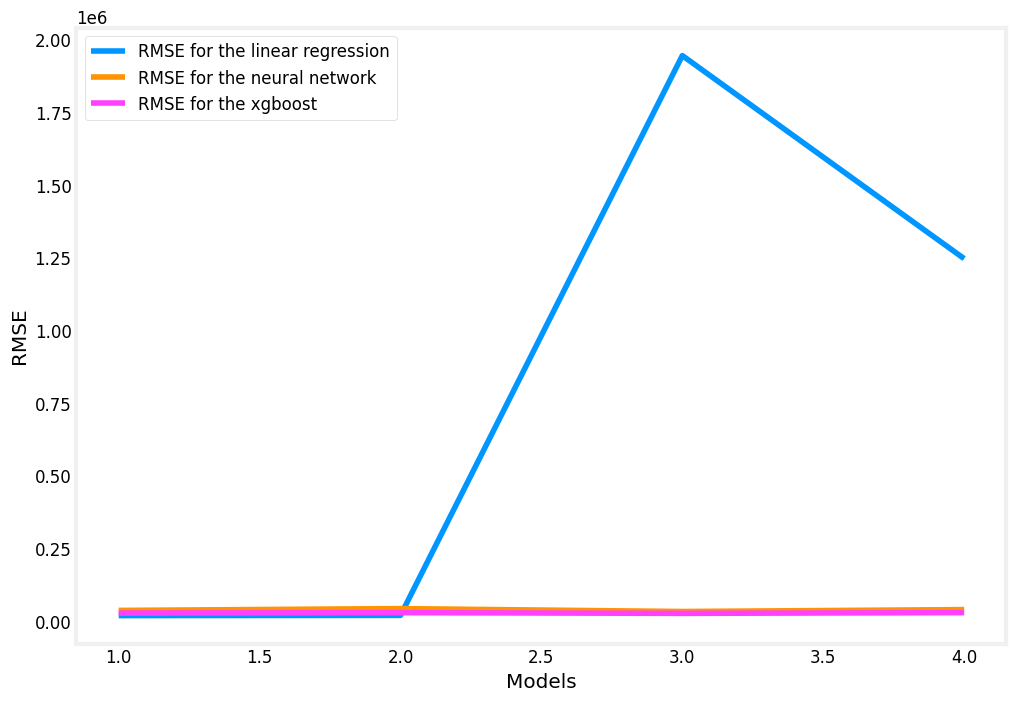

In [87]:
# Visualizing the results of the models
plt.plot(range(1, 5), lr[:, 1], label='RMSE for the linear regression')
plt.plot(range(1, 5), nn[:, 1], label='RMSE for the neural network')
plt.plot(range(1, 5), xg[:, 1], label='RMSE for the xgboost')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [92]:
# Selecting the best model
lr_best = np.min(lr[:, 1])
nn_best = np.min(nn[:, 1])
xg_best = np.min(xg[:, 1])

print(lr_best, nn_best, xg_best)


18369.58805506067 32405.673828125 26017.439453125


In [93]:
# Preprocessing the test data
test_data = './data/test.csv'
df_test = modifying_data(test_data)
df_test = df_test.values
# x_test_map = polys[0].transform(df_test)
X_test_scaled = nn_scaler.transform(df_test)
print(f'Test input after scaling: {X_test_scaled[:2]}')

data before processing...
     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCo

In [94]:
# Using the linear regression model to predict
yhat_test = xg_model[2].predict(X_test_scaled)
yhat_test = yhat_test.flatten()
print(yhat_test[:10])

[129414.48 156184.03 187943.83 183914.3  187527.3  177234.45 175366.64
 166310.61 182020.9  118596.99]


Selecting the neural network for the submission 

In [95]:
# Selecting the neural network cause of its lover CV mse
# Adding the prediction to the submission file
df_sub = pd.read_csv('./data/sample_submission.csv')

new_submission = pd.DataFrame({'Id': df_sub['Id'], 'SalePrice': yhat_test})
new_submission.to_csv('./data/submission2.csv', index=False)
print(len(yhat_test))
print(len(df_sub))

1459
1459
